# Multilingual Text Dataset


In [1]:
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from keras.models import Sequential
from keras import layers
from keras.layers import GRU,Dropout,BatchNormalization
import numpy as np



%matplotlib inline 

Using TensorFlow backend.


**Create a dataframe**

In [2]:
dataset = pd.read_csv('data/dataset.csv', sep='\t', header=None).applymap(str)

**List all languages that are exist in the dataset**

In [3]:
languages = dataset[dataset.columns[0]].unique()
languages

array(['english', 'albanian', 'arabic', 'bulgarian', 'chinese',
       'croatian', 'czech', 'danish', 'dutch', 'estonian', 'finnish',
       'french', 'german', 'greek', 'hebrew', 'hungarian', 'icelandic',
       'italian', 'japanese', 'korean', 'lithuanian', 'norwegian',
       'polish', 'portuguese', 'romanian', 'russian', 'serbian',
       'slovenian', 'spanish', 'swedish', 'turkish', 'ukrainian'],
      dtype=object)

**List all labels (categories)**

In [4]:
categories = dataset[dataset.columns[1]].unique()
categories

array(['advertising', 'agriculture', 'animation', 'arts_and_crafts',
       'entertainment', 'astrology', 'vehicles', 'games',
       'books_and_literature', 'business', 'gambling', 'jobs', 'clothing',
       'comic_books', 'dating', 'education', 'adult', 'food', 'health',
       'hobbies_and_interests', 'humor', 'illegal_content', 'investing',
       'jewelry', 'logistics', 'marketing', 'movies', 'music', 'hacking',
       'media', 'finance', 'pets', 'politics', 'religion',
       'sci_fi_and_fantasy', 'science', 'shopping', 'society', 'sports',
       'tech', 'teens', 'television', 'travel', 'under_construction',
       'weather'], dtype=object)

**now I'm going to create a dataframe containing the number of posts for any pair language/category**

In [5]:
stats = pd.DataFrame(np.zeros([len(languages), len(categories)], dtype=int), index=[i for i in languages],
                     columns=[i for i in categories])

for _, row in dataset.iterrows():
    stats.loc[[row[0]], [row[1]]] += 1

**Let's see how data is ditributed between labels**


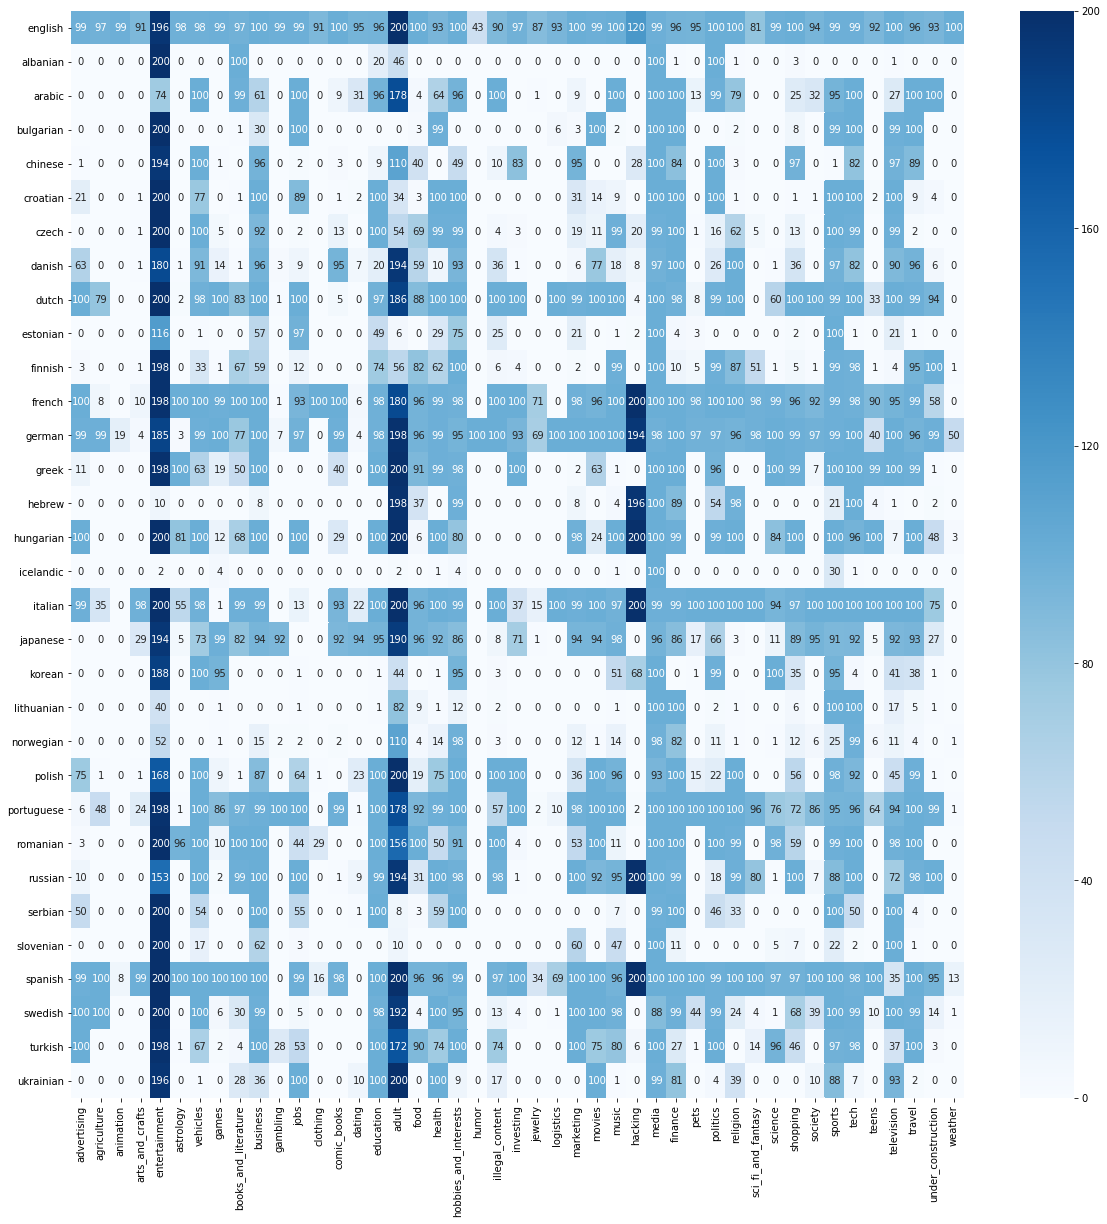

In [6]:
plt.figure(figsize=(20, 20))
sn.heatmap(stats, annot=True, cmap='Blues', fmt='g')
plt.show()

**So now we have an inside look on how this dataset distribution is. It's obvious some category or language don't have much data so it's probably needed to discard it during use in any project.**


In [7]:
# Rename Dataset Columns
dataset.columns = ["Language","Label","Text"]
dataset.head()


,Language,Label,Text
0,english,advertising,Exclusive: U.S. government seeks Facebook help...
1,english,advertising,Trump asks SEC to mull half-year corporate fil...
2,english,advertising,"Wall St. up on trade hopes, S&P equals longest..."
3,english,advertising,"Asian shares hit one-year low on Turkey, China..."
4,english,advertising,"Asian stocks weaken as Turkey worries weigh, d..."


In [8]:
label_encoder = LabelEncoder()
dataset["Label"] = label_encoder.fit_transform(dataset["Label"])
dataset.head()

,Language,Label,Text
0,english,1,Exclusive: U.S. government seeks Facebook help...
1,english,1,Trump asks SEC to mull half-year corporate fil...
2,english,1,"Wall St. up on trade hopes, S&P equals longest..."
3,english,1,"Asian shares hit one-year low on Turkey, China..."
4,english,1,"Asian stocks weaken as Turkey worries weigh, d..."


In [9]:
#Now we have a dataset for each language
languagesData=[]
loc = 0
for i in languages:
    name = languages[loc]+"Data" 
    globals()[name] = pd.DataFrame( dataset[dataset.Language == i])
    loc += 1

## Preprocessing on English data:

1. Convert text to lowercase

In [10]:
def lower_words(text):
    text = text.str.lower()
    return text

englishData['Text'] = lower_words(englishData['Text'])
input_str = englishData['Text']
print(englishData.head())
type(input_str)


  Language  Label                                               Text
0  english      1  exclusive: u.s. government seeks facebook help...
1  english      1  trump asks sec to mull half-year corporate fil...
2  english      1  wall st. up on trade hopes, s&p equals longest...
3  english      1  asian shares hit one-year low on turkey, china...
4  english      1  asian stocks weaken as turkey worries weigh, d...


pandas.core.series.Series

2. Remove URL's

In [11]:
def remove_url(text):
    text = text.apply(lambda x: re.split('https:\/\/.*', str(x))[0])
    return text


englishData['Text'] = remove_url(englishData['Text'])
englishData.head()

    

,Language,Label,Text
0,english,1,exclusive: u.s. government seeks facebook help...
1,english,1,trump asks sec to mull half-year corporate fil...
2,english,1,"wall st. up on trade hopes, s&p equals longest..."
3,english,1,"asian shares hit one-year low on turkey, china..."
4,english,1,"asian stocks weaken as turkey worries weigh, d..."


3. Remove numbers

In [12]:
def remove_numbers(text):
    text = text.str.replace('\d+', '')
    return text


englishData['Text'] = remove_numbers(englishData['Text'])
englishData.head()

,Language,Label,Text
0,english,1,exclusive: u.s. government seeks facebook help...
1,english,1,trump asks sec to mull half-year corporate fil...
2,english,1,"wall st. up on trade hopes, s&p equals longest..."
3,english,1,"asian shares hit one-year low on turkey, china..."
4,english,1,"asian stocks weaken as turkey worries weigh, d..."


4.  Remove punctuation:
    * The following code removes this set of symbols [!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~]:

In [13]:
def remove_punctuations(text):
    text = text.str.replace('[^\w\s]','')
    return text


englishData['Text'] = remove_punctuations(englishData['Text'])
englishData.head()

,Language,Label,Text
0,english,1,exclusive us government seeks facebook help to...
1,english,1,trump asks sec to mull halfyear corporate fili...
2,english,1,wall st up on trade hopes sp equals longest bu...
3,english,1,asian shares hit oneyear low on turkey china w...
4,english,1,asian stocks weaken as turkey worries weigh do...


5. Remove whitespaces. 

In [14]:
def remove_blank_space(col):
    col = col.str.strip()
    col = col.replace('\s+', ' ', regex=True)   
    return col


englishData['Text'] = remove_blank_space(englishData.Text)
englishData.head()

,Language,Label,Text
0,english,1,exclusive us government seeks facebook help to...
1,english,1,trump asks sec to mull halfyear corporate fili...
2,english,1,wall st up on trade hopes sp equals longest bu...
3,english,1,asian shares hit oneyear low on turkey china w...
4,english,1,asian stocks weaken as turkey worries weigh do...


6. Remove stopping words

In [15]:
def remove_stop_words(text, stop):    
    text.apply(lambda x: [item for item in x if item not in stop])
    return text

stop = stopwords.words('english')
remove_stop_words(englishData['Text'],stop)
englishData.head()

,Language,Label,Text
0,english,1,exclusive us government seeks facebook help to...
1,english,1,trump asks sec to mull halfyear corporate fili...
2,english,1,wall st up on trade hopes sp equals longest bu...
3,english,1,asian shares hit oneyear low on turkey china w...
4,english,1,asian stocks weaken as turkey worries weigh do...


7. Stemming

In [16]:
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)


porter_stemmer = PorterStemmer()
englishData['Text'] = englishData['Text'].apply(stem_sentences)
englishData.head()

,Language,Label,Text
0,english,1,exclus us govern seek facebook help to wiretap...
1,english,1,trump ask sec to mull halfyear corpor file vs ...
2,english,1,wall st up on trade hope sp equal longest bull...
3,english,1,asian share hit oneyear low on turkey china wo...
4,english,1,asian stock weaken as turkey worri weigh dolla...


8. Lemmatization

In [17]:
def lemmatize_text(text):
    lemma_tokens =  [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    return ' '.join(lemma_tokens)



w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
englishData['Text']  = englishData.Text.apply(lemmatize_text)
englishData.head()

,Language,Label,Text
0,english,1,exclus u govern seek facebook help to wiretap ...
1,english,1,trump ask sec to mull halfyear corpor file v q...
2,english,1,wall st up on trade hope sp equal longest bull...
3,english,1,asian share hit oneyear low on turkey china wo...
4,english,1,asian stock weaken a turkey worri weigh dollar...


In [18]:
ESentences = englishData.Text
Ey = englishData.Label

In [19]:
Esentences_train, Esentences_test, Ey_train, Ey_test = train_test_split(
   ESentences, Ey, test_size=0.25, random_state=1000)

In [20]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(Esentences_train)

EX_train = tokenizer.texts_to_sequences(Esentences_train)
EX_test = tokenizer.texts_to_sequences(Esentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index


In [21]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [22]:
maxlen = 100

EX_train = pad_sequences(EX_train, padding='post', maxlen=maxlen)
EX_test = pad_sequences(EX_test, padding='post', maxlen=maxlen)

Ey_train = keras.utils.to_categorical(Ey_train)
Ey_test = keras.utils.to_categorical(Ey_test)

print(EX_train[0, :])


[1392   13 1392 2644 1400    2 3829    5 4516    1   44 1756 2804 2694
  539 4431    3  203  214    6    1   70    4  196  814  474    1 2508
   13   92  267 1392  762    1   81  224    6  566    3   20  563 3377
  196  911  267   12    1 4906  575  814   52  367  692  637  312 3416
    5 1264  758    6 1505   98   52  107 4274  267    1  653   51  176
  242   22 4907  840    1 1368  163  123 1696   18   61   60  521    4
  521    4 1572   12   18   40    8 2805 2116  777 2268   44  531 2916
    1 2645]


In [23]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(45, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           3363900   
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               500100    
_________________________________________________________________
dense_2 (Dense)              (None, 45)                4545      
Total params: 3,868,545
Trainable params: 3,868,545
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(EX_train, Ey_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(EX_test, Ey_test))
loss, accuracy = model.evaluate(EX_train, Ey_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(EX_test, Ey_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Train on 3389 samples, validate on 1130 samples
Epoch 1/20
3389/3389 [==============================] - 12s 4ms/step - loss: 3.7374 - acc: 0.0850 - val_loss: 3.6310 - val_acc: 0.1115
Epoch 2/20
3389/3389 [==============================] - 11s 3ms/step - loss: 2.8939 - acc: 0.3562 - val_loss: 3.1856 - val_acc: 0.1823
Epoch 3/20
3389/3389 [==============================] - 11s 3ms/step - loss: 1.3359 - acc: 0.7693 - val_loss: 3.1620 - val_acc: 0.2000
Epoch 4/20
3389/3389 [==============================] - 11s 3ms/step - loss: 0.5862 - acc: 0.8421 - val_loss: 3.2841 - val_acc: 0.2106
Epoch 5/20
3389/3389 [==============================] - 10s 3ms/step - loss: 0.4440 - acc: 0.8613 - val_loss: 3.2952 - val_acc: 0.2230
Epoch 6/20
3389/3389 [==============================] - 11s 3ms/step - loss: 0.3779 - acc: 0.8699 - val_loss: 3.3120 - val_acc: 0.2274
Epoch 7/20
3389/3389 [==============================] - 15s 4ms/step - loss: 0.3443 - acc: 0.8746 - val_loss: 3.3197 - val_acc: 0.2221
Epoch 8

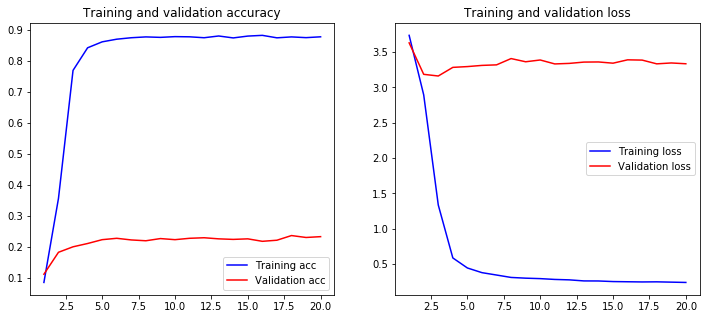

In [25]:
plot_history(history)

Using pretrained word embeddings

In [26]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [27]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    'glove.6B.50d.txt',
    tokenizer.word_index, embedding_dim)


In [28]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.33749516929754153

In [29]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(GRU(256))
model.add(Dropout(0.2))
model.add(layers.Dense(45, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           3363900   
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               235776    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 45)                11565     
Total params: 3,611,241
Trainable params: 3,611,241
Non-trainable params: 0
_________________________________________________________________


Train on 3389 samples, validate on 1130 samples
Epoch 1/10
3389/3389 [==============================] - 75s 22ms/step - loss: 3.7344 - acc: 0.0667 - val_loss: 3.6273 - val_acc: 0.1115
Epoch 2/10
3389/3389 [==============================] - 51s 15ms/step - loss: 3.5465 - acc: 0.1207 - val_loss: 3.5142 - val_acc: 0.1425
Epoch 3/10
3389/3389 [==============================] - 48s 14ms/step - loss: 3.2693 - acc: 0.1750 - val_loss: 3.2355 - val_acc: 0.1673
Epoch 4/10
3389/3389 [==============================] - 48s 14ms/step - loss: 2.8908 - acc: 0.2449 - val_loss: 3.0560 - val_acc: 0.2195
Epoch 5/10
3389/3389 [==============================] - 48s 14ms/step - loss: 2.5415 - acc: 0.3243 - val_loss: 2.8208 - val_acc: 0.2602
Epoch 6/10
3389/3389 [==============================] - 48s 14ms/step - loss: 2.2361 - acc: 0.3836 - val_loss: 2.8151 - val_acc: 0.2743
Epoch 7/10
3389/3389 [==============================] - 51s 15ms/step - loss: 2.0402 - acc: 0.4346 - val_loss: 2.8560 - val_acc: 0.2584


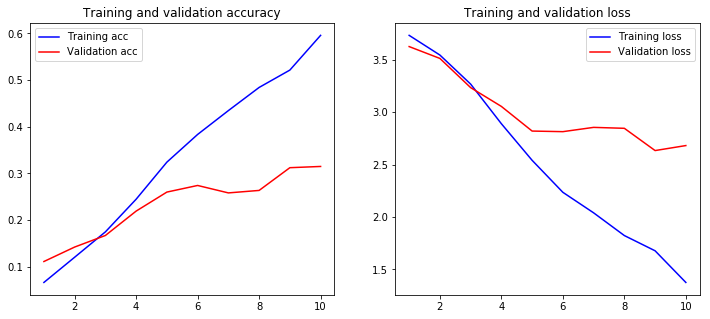

In [30]:
history = model.fit(EX_train, Ey_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(EX_test, Ey_test)
                   )
loss, accuracy = model.evaluate(EX_train, Ey_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(EX_test, Ey_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Train on 3389 samples, validate on 1130 samples
Epoch 1/50
3389/3389 [==============================] - 48s 14ms/step - loss: 1.1984 - acc: 0.6621 - val_loss: 2.6723 - val_acc: 0.3283
Epoch 2/50
3389/3389 [==============================] - 50s 15ms/step - loss: 1.0382 - acc: 0.6976 - val_loss: 2.6736 - val_acc: 0.3416
Epoch 3/50
3389/3389 [==============================] - 62s 18ms/step - loss: 0.8808 - acc: 0.7389 - val_loss: 2.7328 - val_acc: 0.3381
Epoch 4/50
3389/3389 [==============================] - 64s 19ms/step - loss: 0.7775 - acc: 0.7725 - val_loss: 2.7530 - val_acc: 0.3522
Epoch 5/50
3389/3389 [==============================] - 65s 19ms/step - loss: 0.7099 - acc: 0.7793 - val_loss: 2.7969 - val_acc: 0.3566
Epoch 6/50
3389/3389 [==============================] - 63s 19ms/step - loss: 0.6235 - acc: 0.8126 - val_loss: 2.8608 - val_acc: 0.3416
Epoch 7/50
3389/3389 [==============================] - 65s 19ms/step - loss: 0.5261 - acc: 0.8286 - val_loss: 2.9352 - val_acc: 0.3407


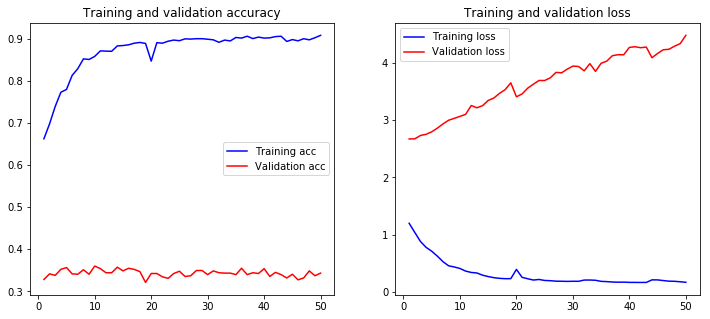

In [31]:
history = model.fit(EX_train, Ey_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(EX_test, Ey_test)
                   )
loss, accuracy = model.evaluate(EX_train, Ey_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(EX_test, Ey_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)